In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Constants
DATA_PATH = '../data/processed/preprocessed_v1.csv'

# Carreguem les dades
df = pd.read_csv(DATA_PATH)

# Variables per al clustering (les mateixes que es van usar originalment)
CLUSTERING_VARS = [
    'FIGO2023',
    'recep_est_porcent',
    'afectacion_linf',
    'grado_histologi',
    'edad',
    'imc',
    'infiltracion_mi',
    'rece_de_Ppor'
]

# Preparem les dades per al clustering
X = df[CLUSTERING_VARS].copy()

# Imputem valors faltants amb la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Escalem les dades
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apliquem K-Means (assumint k=3 com a l'anàlisi original)
N_CLUSTERS = 2
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Dataset carregat: {df.shape[0]} files, {df.shape[1]} columnes")
print(f"Variables de clustering: {CLUSTERING_VARS}")
print(f"\nTotal d'individus per clúster:")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  Clúster {cluster}: {count} individus")
print(f"\nTotal: {cluster_counts.sum()} individus")

Dataset carregat: 154 files, 57 columnes
Variables de clustering: ['FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor']

Total d'individus per clúster:
  Clúster 0: 43 individus
  Clúster 1: 111 individus

Total: 154 individus


In [42]:
# Mapeig dels noms dels clústers segons les regles de negoci (Agent.MD)
# 0 -> Alt Risc (Sol·licitat)
# 1 -> Baix Risc (Sol·licitat)
# 2 -> Mitjà Risc (Deduït per completar els 3 nivells especificats a la documentació)
cluster_mapping = {
    0: 'Alt Risc',
    1: 'Baix Risc',
    2: 'Mitjà Risc'
}

# Apliquem el canvi de nom a la columna 'cluster'
if 'cluster' in df.columns:
    df['cluster'] = df['cluster'].replace(cluster_mapping)
    
# Verifiquem els nous noms
print(f"Nous noms de clústers: {df['cluster'].unique()}")

# Definir l'ordre correcte per a les visualitzacions (de menys a més risc o viceversa)
risk_order = ['Baix Risc', 'Mitjà Risc', 'Alt Risc']
df['cluster'] = pd.Categorical(df['cluster'], categories=risk_order, ordered=True)

Nous noms de clústers: ['Alt Risc' 'Baix Risc']


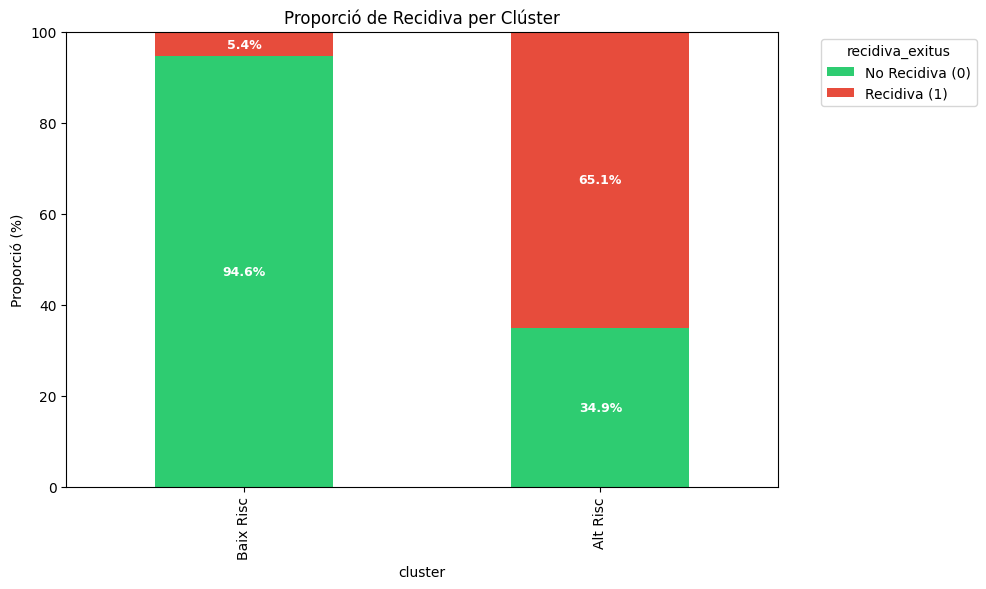

In [43]:
from matplotlib.colors import ListedColormap

def plot_stacked_normalized(df, x_col, hue_col, title):
    """
    Plots a normalized (100%) stacked bar chart showing proportions.
    Uses green (no recurrence) and red (recurrence) colors.
    """
    # Calculem la taula de contingència normalitzada
    crosstab = pd.crosstab(df[x_col], df[hue_col], normalize='index') * 100
    
    # Colors: Verd per 0 (no recidiva), Vermell per 1 (recidiva)
    colors = ['#2ecc71', '#e74c3c']  # Green, Red
    
    # Creem el gràfic
    ax = crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Proporció (%)')
    plt.legend(title=hue_col, labels=['No Recidiva (0)', 'Recidiva (1)'], 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 100)

    # Afegim els percentatges dins de les barres
    for c in ax.containers:
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', fontsize=9, color='white')

    plt.tight_layout()
    plt.show()

# Visualitzem NOMÉS la proporció del target (recidiva) per clúster
plot_stacked_normalized(
    df, 
    x_col='cluster', 
    hue_col='recidiva_exitus', 
    title='Proporció de Recidiva per Clúster'
)

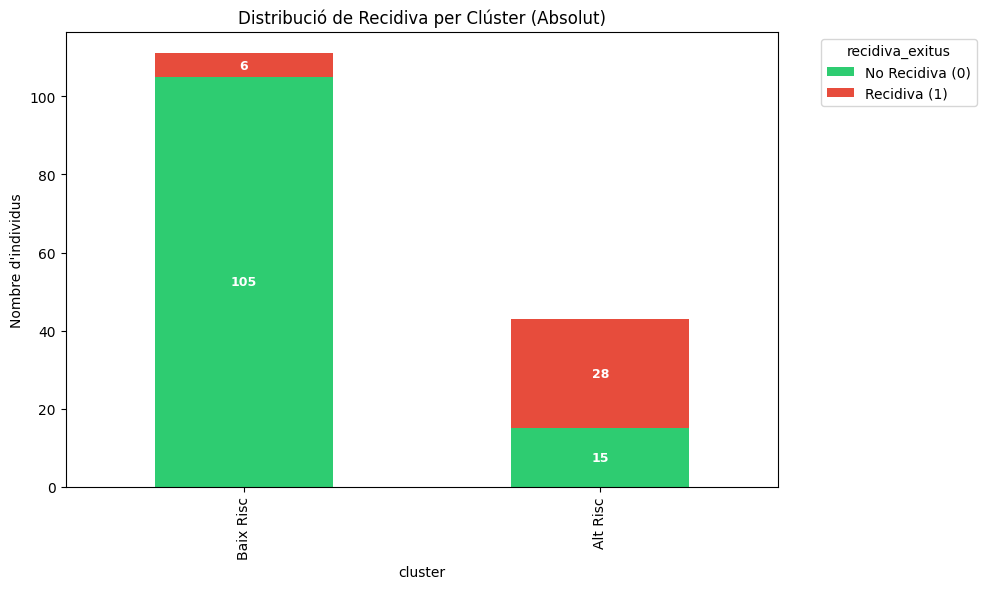

In [44]:
def plot_stacked_count_target(df, x_col, hue_col, title):
    """
    Plots a stacked bar chart showing counts (absolute numbers).
    Uses green (no recurrence) and red (recurrence) colors.
    """
    # Calculem la taula de contingència amb counts absoluts
    crosstab = pd.crosstab(df[x_col], df[hue_col])
    
    # Colors: Verd per 0 (no recidiva), Vermell per 1 (recidiva)
    colors = ['#2ecc71', '#e74c3c']  # Green, Red
    
    # Creem el gràfic
    ax = crosstab.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel('Nombre d\'individus') # Canviat a Count
    plt.legend(title=hue_col, labels=['No Recidiva (0)', 'Recidiva (1)'], 
               bbox_to_anchor=(1.05, 1), loc='upper left')

    # Afegim els números absoluts dins de les barres
    for c in ax.containers:
        # Mostrem el valor absolut si és > 0
        labels = [f'{v.get_height():.0f}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', fontsize=9, color='white')

    plt.tight_layout()
    plt.show()

# Visualitzem Stacked Barchart (Count) de Recidiva per Clúster
plot_stacked_count_target(
    df, 
    x_col='cluster', 
    hue_col='recidiva_exitus', 
    title='Distribució de Recidiva per Clúster (Absolut)'
)

In [45]:
def plot_area_distribution(df, col, cluster_col='cluster', title=None):
    """
    Plots overlapping area charts (KDE) for each cluster on the same axes.
    Uses highly differentiated colors.
    """
    clusters = sorted(df[cluster_col].unique())
    
    # Paleta de colors molt diferenciats
    colors = ['#3498db', '#e67e22', '#9b59b6', '#1abc9c', '#e74c3c']  # Blau, Taronja, Porpra, Turquesa, Vermell
    
    plt.figure(figsize=(10, 6))
    
    for i, cluster in enumerate(clusters):
        subset = df[df[cluster_col] == cluster][col].dropna()
        if len(subset) > 1:
            sns.kdeplot(
                data=subset, 
                fill=True, 
                alpha=0.35, 
                color=colors[i % len(colors)], 
                label=f'Clúster {cluster}',
                linewidth=2.5
            )
    
    plt.title(title if title else f'Distribució de {col} per Clúster')
    plt.xlabel(col)
    plt.ylabel('Densitat')
    plt.legend(title='Clúster')
    plt.tight_layout()
    plt.show()

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_area_distribution(df, col, cluster_col='cluster', title=None):
    """
    Plots overlapping area charts (KDE) for each cluster on the same axes.
    """
    clusters = sorted(df[cluster_col].unique())
    
    # CAMBIO: Paleta personalizada "Naranja y Azules"
    # Cluster 0 -> Naranja, Cluster 1 -> Azul fuerte, Cluster 2 -> Azul claro
    colors = ['#ff7f0e', '#1f77b4', '#aec7e8'] 
    
    # Si hay más de 3 clústers, extendemos con más tonos si fuera necesario
    if len(clusters) > len(colors):
         colors = sns.color_palette("Oranges_d", n_colors=len(clusters)) + sns.color_palette("Blues_d", n_colors=len(clusters))

    plt.figure(figsize=(10, 6))
    
    for i, cluster in enumerate(clusters):
        subset = df[df[cluster_col] == cluster][col].dropna()
        if len(subset) > 1:
            # KDE plot amb àrea omplerta
            # Usamos el color correspondiente al índice del clúster (asegurando no salirnos del rango)
            color_idx = i % len(colors)
            sns.kdeplot(
                data=subset, 
                fill=True, 
                alpha=0.4, 
                color=colors[color_idx], 
                label=f'Clúster {cluster}',
                linewidth=2
            )
    
    plt.title(title if title else f'Distribució de {col} per Clúster')
    plt.xlabel(col)
    plt.ylabel('Densitat')
    plt.legend(title='Clúster')
    plt.tight_layout()
    plt.show()

Generant gràfics per a les variables de clustering: ['FIGO2023', 'recep_est_porcent', 'afectacion_linf', 'grado_histologi', 'edad', 'imc', 'infiltracion_mi', 'rece_de_Ppor']


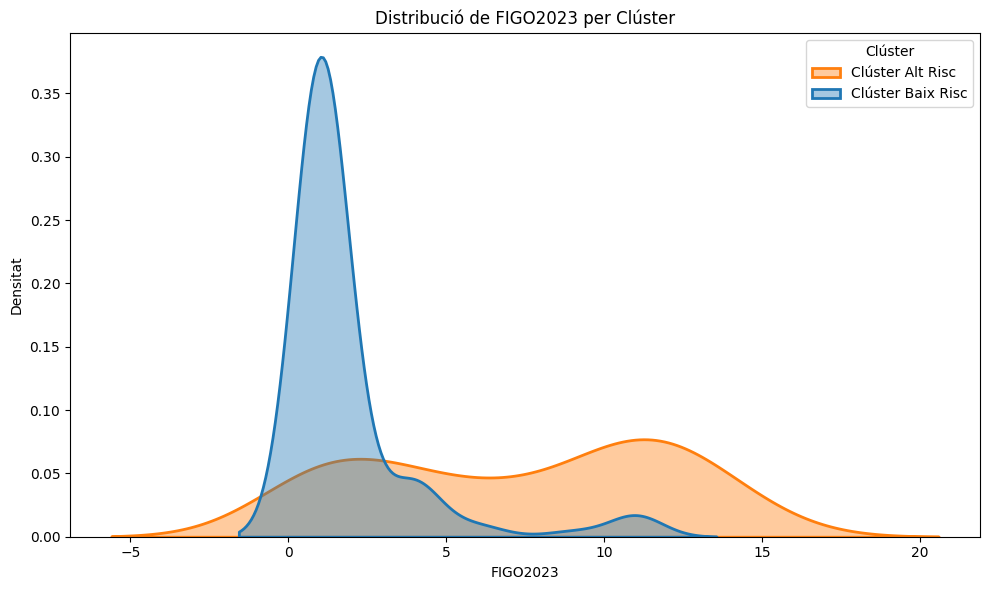

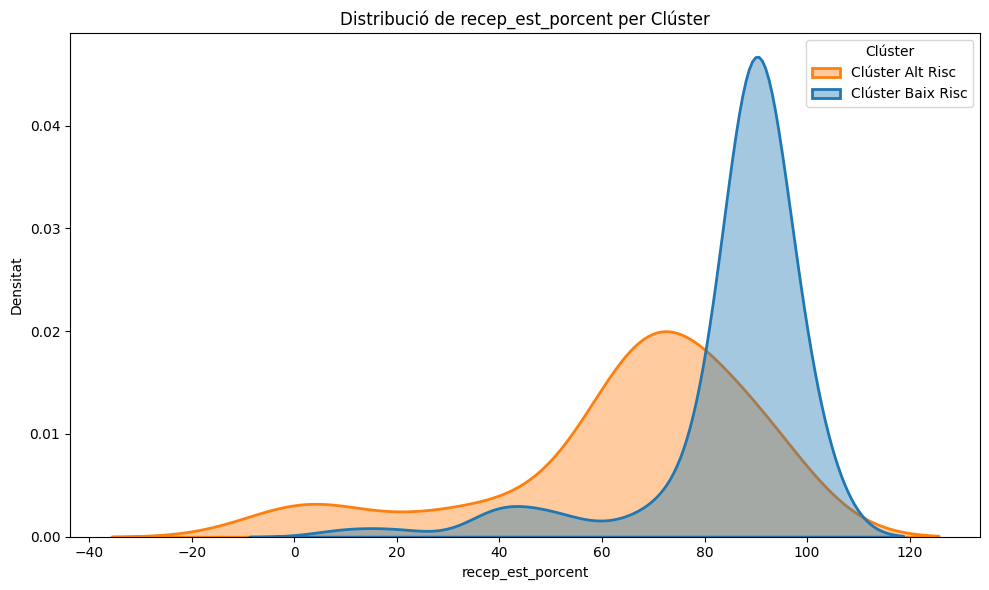

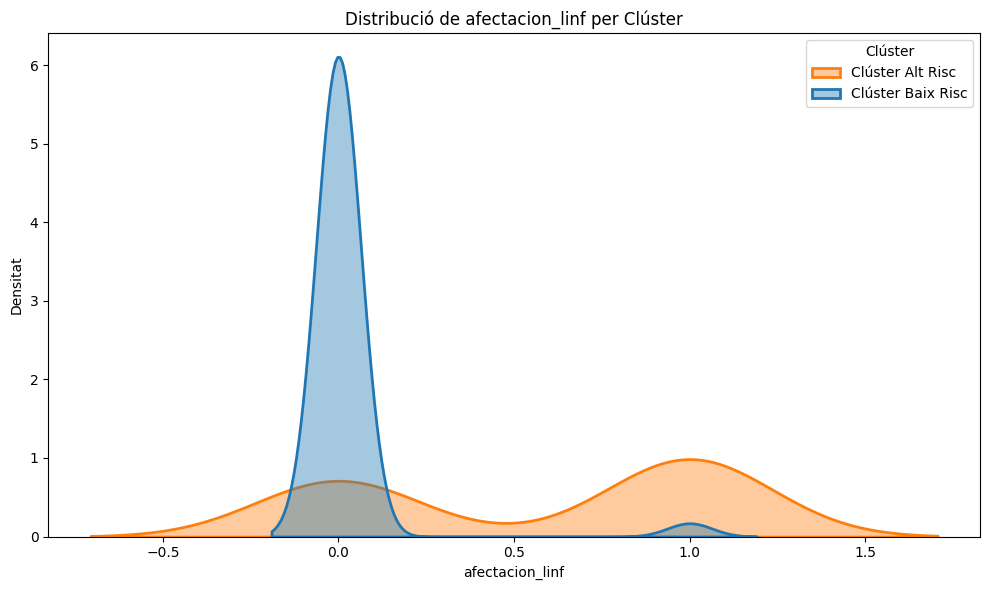

C:\Users\paugi\AppData\Local\Temp\ipykernel_18616\264190124.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


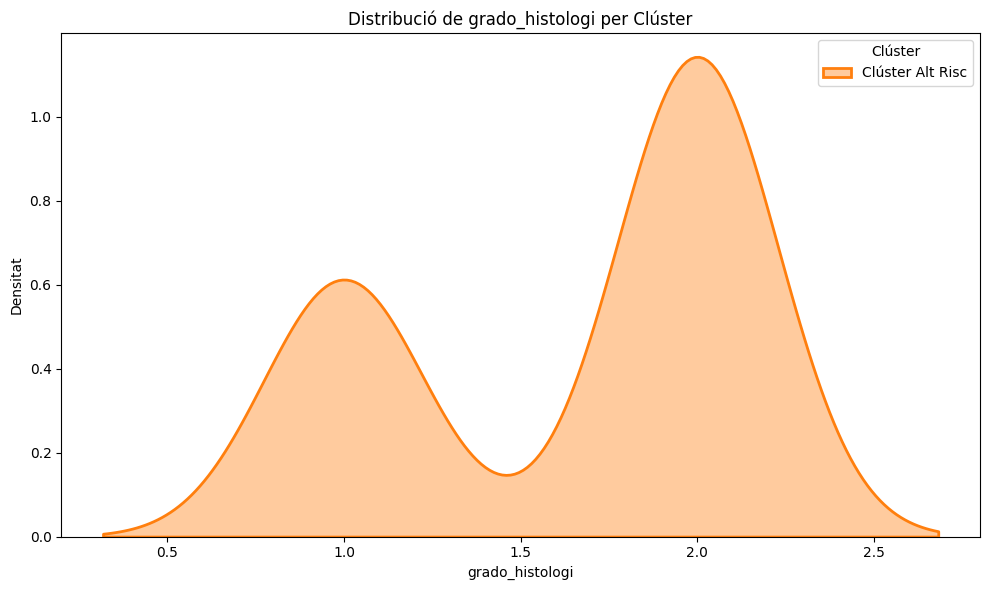

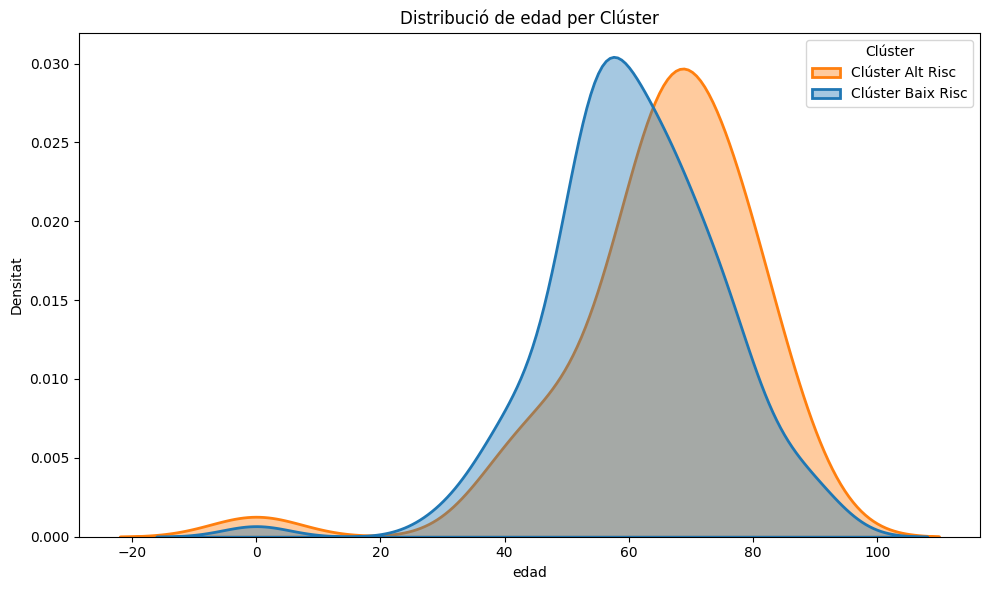

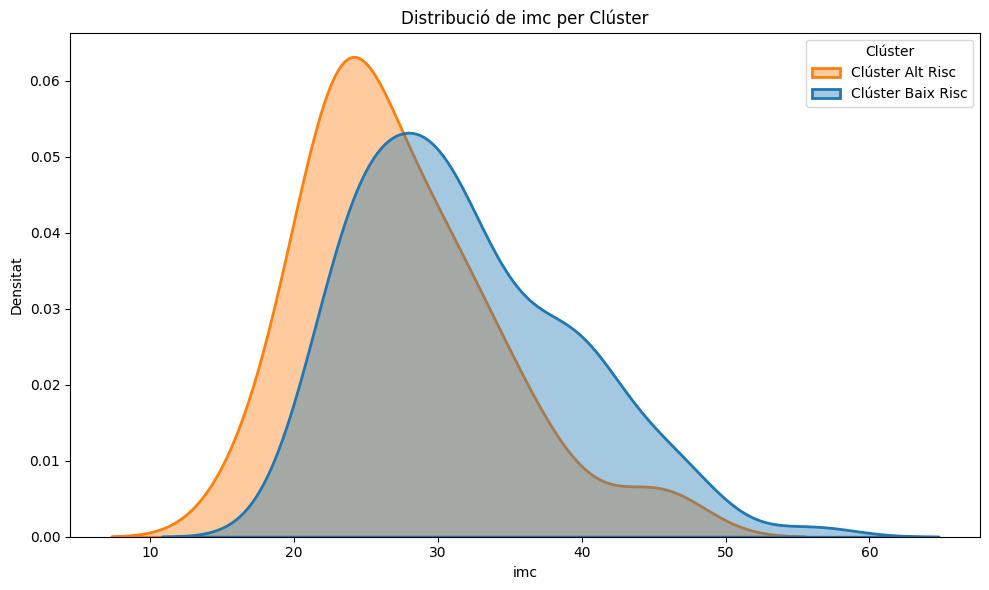

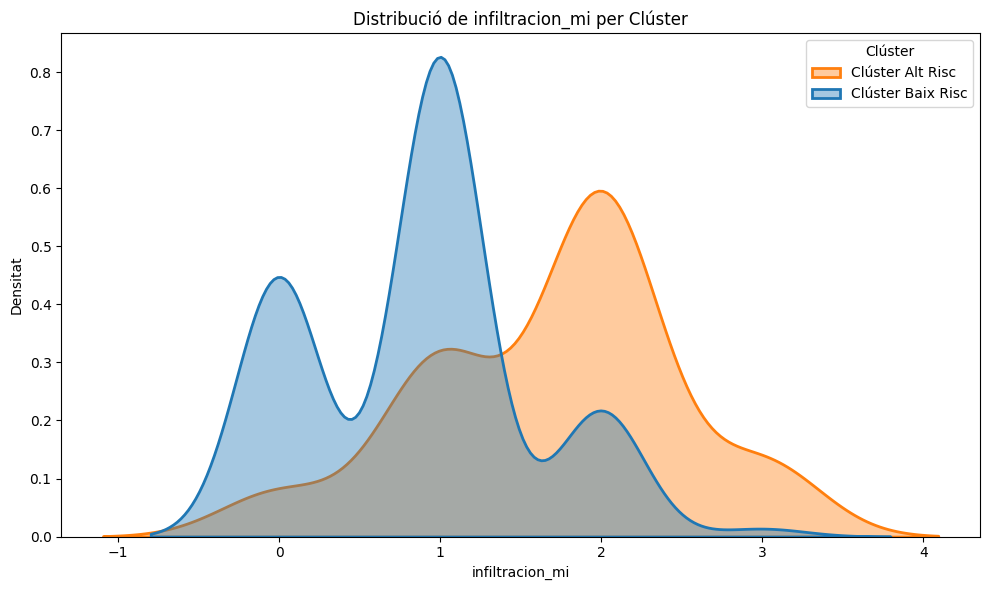

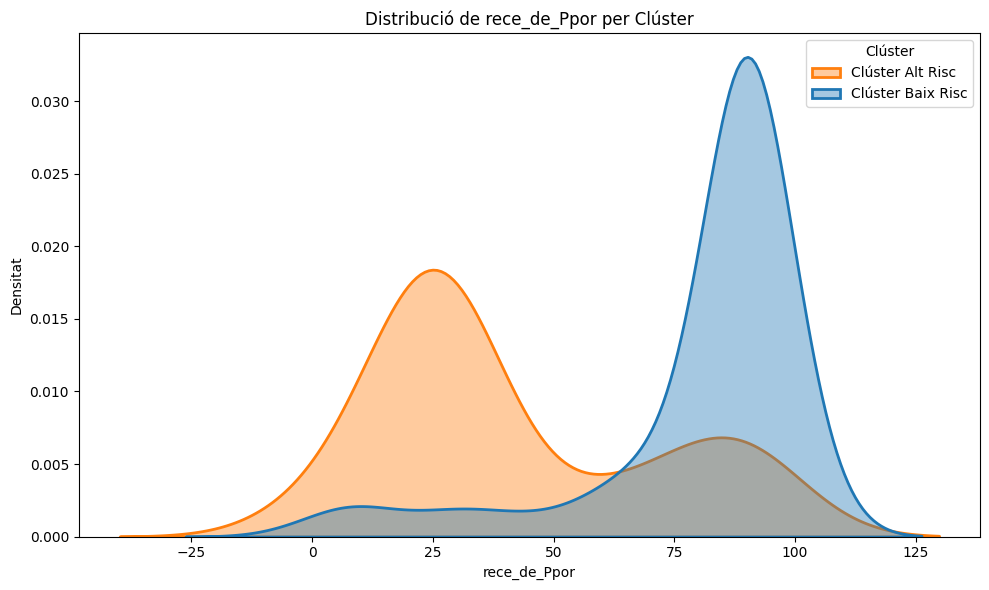

In [47]:
# Generem un area chart per a cada variable usada en el clustering
print(f"Generant gràfics per a les variables de clustering: {CLUSTERING_VARS}")

for col in CLUSTERING_VARS:
    plot_area_distribution(
        df, 
        col=col, 
        cluster_col='cluster',
        title=f'Distribució de {col} per Clúster'
    )

In [48]:
from sklearn.neighbors import NearestNeighbors

# Entrenem el model KNN amb les dades escalades
K_NEIGHBORS = 20
knn = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric='euclidean')
knn.fit(X_scaled)

def predict_individual(individual_data, df, X_scaled, kmeans, knn, scaler, imputer, 
                        clustering_vars, k=5):
    """
    Dado un individuo, retorna:
    - El cluster al que pertenece
    - Los k casos más similares
    - La probabilidad estimada de recidiva
    
    Parameters:
    -----------
    individual_data : dict
        Diccionario con los valores de las variables de clustering
        Ejemplo: {'FIGO2023': 4, 'recep_est_porcent': 80, ...}
    """
    # Preparem les dades de l'individu
    individual_df = pd.DataFrame([individual_data])
    X_ind = individual_df[clustering_vars].values
    
    # Imputem i escalem
    X_ind_imputed = imputer.transform(X_ind)
    X_ind_scaled = scaler.transform(X_ind_imputed)
    
    # Determinem el cluster
    cluster = kmeans.predict(X_ind_scaled)[0]
    
    # Trobem els k veïns més propers
    distances, indices = knn.kneighbors(X_ind_scaled)
    
    # Obtenim els casos similars
    similar_cases = df.iloc[indices[0]].copy()
    similar_cases['distance'] = distances[0]
    
    # Calculem la probabilitat de recidiva
    recurrence_prob = similar_cases['recidiva_exitus'].mean()
    recurrence_count = similar_cases['recidiva_exitus'].sum()
    
    return {
        'cluster': cluster,
        'similar_cases': similar_cases,
        'recurrence_probability': recurrence_prob,
        'recurrence_count': recurrence_count,
        'total_neighbors': k
    }

def display_prediction(result):
    """
    Mostra els resultats de forma clara.
    """
    print("=" * 60)
    print("RESULTATS DE L'ANÀLISI")
    print("=" * 60)
    
    print(f"\n🔹 CLÚSTER ASSIGNAT: {result['cluster']}")
    
    print(f"\n🔹 PROBABILITAT DE RECIDIVA: {result['recurrence_probability']*100:.1f}%")
    print(f"   ({result['recurrence_count']}/{result['total_neighbors']} veïns amb recidiva)")
    
    # Semàfor de risc
    prob = result['recurrence_probability']
    if prob < 0.3:
        risk = "🟢 BAIX RISC"
    elif prob < 0.6:
        risk = "🟡 RISC MITJÀ"
    else:
        risk = "🔴 ALT RISC"
    print(f"\n🔹 NIVELL DE RISC: {risk}")
    
    print(f"\n🔹 CASOS MÉS SIMILARS (k={result['total_neighbors']}):")
    print("-" * 60)
    
    # Mostrem els casos similars amb informació rellevant
    display_cols = ['recidiva_exitus', 'distance'] + CLUSTERING_VARS
    display_df = result['similar_cases'][display_cols].copy()
    display_df['distance'] = display_df['distance'].round(3)
    print(display_df.to_string(index=True))
    
    print("=" * 60)

In [49]:
# Exemple: Definim un nou individu amb les seves característiques
nou_individu = {
    'FIGO2023': 4.0,          # Estadi FIGO
    'recep_est_porcent': 80.0, # Receptors estrogen (%)
    'afectacion_linf': 0.0,    # Afectació limfàtica (0=No, 1=Sí)
    'grado_histologi': 1.0,    # Grau histològic
    'edad': 65.0,              # Edat
    'imc': 32.0,               # IMC
    'infiltracion_mi': 2.0,    # Infiltració miometrial
    'rece_de_Ppor': 70.0       # Receptors progesterona (%)
}

# Fem la predicció
result = predict_individual(
    individual_data=nou_individu,
    df=df,
    X_scaled=X_scaled,
    kmeans=kmeans,
    knn=knn,
    scaler=scaler,
    imputer=imputer,
    clustering_vars=CLUSTERING_VARS,
    k=K_NEIGHBORS
)

# Mostrem els resultats
display_prediction(result)

RESULTATS DE L'ANÀLISI

🔹 CLÚSTER ASSIGNAT: 1

🔹 PROBABILITAT DE RECIDIVA: 5.0%
   (1/20 veïns amb recidiva)

🔹 NIVELL DE RISC: 🟢 BAIX RISC

🔹 CASOS MÉS SIMILARS (k=20):
------------------------------------------------------------
     recidiva_exitus  distance  FIGO2023  recep_est_porcent  afectacion_linf  grado_histologi  edad   imc  infiltracion_mi  rece_de_Ppor
148                0     0.665       4.0               90.0              0.0              1.0  63.0  28.7              2.0          70.0
143                0     0.974       6.0               90.0              0.0              1.0  64.0  32.8              2.0          90.0
17                 0     0.996       4.0               90.0              0.0              1.0  58.0  34.1              2.0          90.0
141                0     1.052       4.0               90.0              0.0              1.0  73.0  29.4              2.0          90.0
114                0     1.245       4.0              100.0              0.0        

c:\Users\paugi\.gemini\antigravity\scratch\bitsXlamarato-2025-oncometric\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [50]:
def input_individual():
    """
    Funció interactiva per introduir les dades d'un individu.
    """
    print("Introdueix les dades del pacient:")
    print("-" * 40)
    
    individual = {
        'FIGO2023': float(input("FIGO2023 (1-14): ")),
        'recep_est_porcent': float(input("Receptors Estrogen % (0-100): ")),
        'afectacion_linf': float(input("Afectació Limfàtica (0=No, 1=Sí): ")),
        'grado_histologi': float(input("Grau Histològic (1 o 2): ")),
        'edad': float(input("Edat: ")),
        'imc': float(input("IMC: ")),
        'infiltracion_mi': float(input("Infiltració Miometrial (0-3): ")),
        'rece_de_Ppor': float(input("Receptors Progesterona % (0-100): "))
    }
    
    return individual

# Per usar la funció interactiva, descomenta les línies següents:
# nou_individu = input_individual()
# result = predict_individual(nou_individu, df, X_scaled, kmeans, knn, scaler, imputer, CLUSTERING_VARS, K_NEIGHBORS)
# display_prediction(result)

In [ ]:
# --- ANÀLISI DE COMPONENTS PRINCIPALS (PCA) ---
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Aplicar PCA (2 Components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Crear DataFrame amb resultats
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['cluster']
if 'recidiva_exitus' in df.columns:
    pca_df['Target'] = df['recidiva_exitus']
    pca_df['Target_Label'] = pca_df['Target'].map({0: 'No Recidiva', 1: 'Recidiva'})

print("PCA calculat correctament.")
print(f"Variança explicada per component: {pca.explained_variance_ratio_}")
print(f"Variança total explicada (2 components): {sum(pca.explained_variance_ratio_):.4f}")

In [ ]:
# 3. Visualització del PCA
plt.figure(figsize=(14, 6))

# Plot 1: PCA per Clúster
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', style='Cluster', s=100, alpha=0.8)
plt.title('Projecció PCA per Clúster K-Means')
plt.grid(True, alpha=0.3)

# Plot 2: PCA per Target (Recidiva)
if 'Target' in pca_df.columns:
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='PC1', y='PC2', hue='Target_Label', data=pca_df, 
                    palette={'No Recidiva': '#2ecc71', 'Recidiva': '#e74c3c'}, style='Target_Label', s=100, alpha=0.8)
    plt.title('Projecció PCA per Recidiva/Exitus')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 4. Biplot (Opcional - per veure influència de variables)
# Aquest gràfic mostra quines variables contribueixen més a PC1 i PC2
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.3)

# Reconstruct loadings scaled
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features = CLUSTERING_VARS

for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0]*5, loadings[i, 1]*5, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*5.2, loadings[i, 1]*5.2, feature, color='black', ha='center', va='center')

plt.title('PCA Biplot - Influència de les Variables')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid()
plt.show()